In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import animation, rc
from IPython.display import HTML
import dedalus.public as d3
from tqdm import tqdm
import os
import json
from datetime import datetime
import logging
logger = logging.getLogger(__name__)
import argparse
import shutil
import h5py
from glob import glob
import warnings
import scipy.special as special

# Schelling mean field model

Simulating the derived mean-field equations for Schelling dynamics, given by

$$
\begin{aligned}
    \partial_t \phi^\mu(\vec{x}, t) &= - \nabla \cdot \vec{J}^\mu\\
    \vec{J}^\mu(\vec{x}, t) &= - \sum_\nu D^{\mu\nu}(\vec{\phi}) \ \nabla \phi^\mu \\
    D^{\mu \nu}(\vec{\phi}) &= T \delta^{\mu \nu} - \phi^\mu (1 - \phi) \partial_\nu g^\mu(\vec{\phi}) \\
    g^\mu(\vec{\phi}) &= (1 - \alpha) \pi^\mu(\vec{\phi}) + \alpha \partial_\mu \left( \vec{\phi} \cdot \vec{\pi}(\vec{\phi}) \right)
\end{aligned}
$$
where $\partial_\mu \equiv \partial / \partial \phi^\mu$. The fitness of species $\mu$ depends on the density of both species and is given by 
$$\pi^\mu(\vec{\phi}) = \pi(\phi^\mu) + \delta \sum_\nu \epsilon_{\mu \nu} \pi(\phi^\nu)$$
where $\epsilon_{\mu \nu}$ is the totally-antisymetric tensor (practically, $\pi^A = \pi(\phi^A) + \delta \pi(\phi^B)$ and $\pi^B = \pi(\phi^B) - \delta \pi(\phi^A)$).

Here, we take the fitness $\pi(\phi) = 4 \phi(1 - \phi)$.

Once we plug everything in and do some simplifications, the diffusion matrix becomes

$$
\begin{aligned}
D &= \begin{pmatrix}
T - \phi^A (1 - \phi)\left[ (1 + \alpha) \pi'(\phi^A) + \alpha (\phi^A - \delta \phi^B) \pi''(\phi^A) \right] & -\delta \ \phi^A (1 - \phi) \left[ \pi'(\phi^B) - \alpha \pi'(\phi^A) \right]
\\
+\delta \ \phi^B (1 - \phi) \left[ \pi'(\phi^A) - \alpha \pi'(\phi^B) \right] & T - \phi^B (1 - \phi)\left[ (1 + \alpha) \pi'(\phi^B) + \alpha (\phi^B + \delta \phi^A) \pi''(\phi^B) \right]
\end{pmatrix}
\\
D &= T \mathbb{I} - (1 - \phi)
\begin{pmatrix}
\phi^A \left[ (1 + \alpha) \pi'(\phi^A) + \alpha (\phi^A - \delta \phi^B) \pi''(\phi^A) \right] & +\delta \ \phi^A \left[ \pi'(\phi^B) - \alpha \pi'(\phi^A) \right]
\\
-\delta \ \phi^B \left[ \pi'(\phi^A) - \alpha \pi'(\phi^B) \right] & \phi^B \left[ (1 + \alpha) \pi'(\phi^B) + \alpha (\phi^B + \delta \phi^A) \pi''(\phi^B) \right]
\end{pmatrix}
\end{aligned}
$$

In [5]:
# for savefiles name
# savefolder = "/Users/danny/Library/CloudStorage/GoogleDrive-dsseara@uchicago.edu/My Drive/uchicago/adaptation/schelling/2023-05-08_schelling1D2S_meanField"
# shutil.rmtree(savefolder, ignore_errors=True)

# simulation parameters
Lx = 40
Nx = 64
t_stop = 1000
Δt = 1e-2
dealias = 3/2
timestepper = d3.SBDF2
dtype = np.float64

# check stability criterion
Δx = Lx / Nx
if Δt * Δx**(-4) > 1/8:
    warnings.warn("von Neumann stability not satisfied")

# initial condition parameters
λ = Lx / 2
k = 2 * np.pi / λ
ϕA0 = 1/4
δϕA = 0.05
ϕB0 = 1/4
δϕB = 0.05

# Schelling model parameters
α = 0.0
κ = +0.5
δ = 1
Tc = (1 + α) * ϕA0
T = 0.1
ΓA = 1.0
ΓB = 1.0

# 1D bases
coord = d3.Coordinate('x')
dist = d3.Distributor(coord, dtype=dtype)
xbasis = d3.RealFourier(coord, Nx, bounds=(-Lx/2, Lx/2), dealias=dealias)

# fields
ϕA = dist.Field(name="phiA", bases=(xbasis))
ϕB = dist.Field(name="phiB", bases=(xbasis))

# problem
problem = d3.IVP([ϕA, ϕB], namespace=locals())

# substitutions
dx = lambda A: d3.Differentiate(A, coord)
# mobilities
μA = ϕA * (1 - ϕA - ϕB)
μB = ϕB * (1 - ϕA - ϕB)

# fitness and derivative
π = lambda x: x - 1
dπ = lambda x: 1

# πA, dπA/dϕA, and dπA/dϕB
# πA = π(ϕA) + (κ - δ) * ϕB / 2
# dπA_dϕA = dπ(ϕA)
# dπA_dϕB = (κ - δ) / 2
πA = ϕA / (ϕA + ϕB)
dπA_dϕA = ϕB / (ϕA + ϕB)**2
dπA_dϕB = -ϕA / (ϕA + ϕB)**2
# # πB, dπA/dϕA, and dπA/dϕB
# πB = π(ϕB) + (κ + δ) * ϕA / 2
# dπB_dϕA = (κ + δ) / 2
# dπB_dϕB = dπ(ϕB)
πB = (ϕA / (ϕA + ϕB)) * (1 - (ϕA / (ϕA + ϕB)))
dπB_dϕA = ϕB * (ϕB - ϕA) / (ϕA + ϕB)**3
dπB_dϕB = ϕA * (ϕA - ϕB) / (ϕA + ϕB)**3

# total fitness
U = ϕA * πA + ϕB * πB
dU_dϕA = πA + ϕA * dπA_dϕA + ϕB * dπB_dϕA
dU_dϕB = πB + ϕB * dπB_dϕB + ϕA * dπA_dϕB


### Schelling ####
# add equation
problem.add_equation("dt(ϕA) - T*dx(dx(ϕA)) = T*(ϕA * dx(dx(ϕB)) - ϕB * dx(dx(ϕA))) - dx(μA * ((1 - α) * dx(πA) + α * dx(dU_dϕA))) - dx(ΓA * μA * dx(dx(dx(ϕA))))")
problem.add_equation("dt(ϕB) - T*dx(dx(ϕB)) = T*(ϕB * dx(dx(ϕA)) - ϕA * dx(dx(ϕB))) - dx(μB * ((1 - α) * dx(πB) + α * dx(dU_dϕB))) - dx(ΓB * μB * dx(dx(dx(ϕB))))")
#################

# solver and stopping
solver = problem.build_solver(timestepper)
solver.stop_sim_time = t_stop

# initial condition
x = dist.local_grid(xbasis)
randA = np.random.uniform(low=-1, high=+1, size=Nx)
randA -= randA.mean()
randB = np.random.uniform(low=-1, high=+1, size=Nx)
randB -= randB.mean()
ϕA["g"] =  ϕA0 + 0 * δϕA * np.sin(k * x) + 1 * δϕA * randA
# smooth_top_hat(x, +5, 10, 1)
ϕB["g"] =  ϕB0 + 0 * δϕB * np.sin(k * x + np.pi/2) + 1 * δϕB * randB
# smooth_top_hat(x, -5, 10, 1)

# storage
# snapshots = solver.evaluator.add_file_handler(savefolder,
#                                               sim_dt=0.05,
#                                               max_writes=500)
# snapshots.add_task(ϕA, layout="g", name="phiA")
# snapshots.add_task(ϕB, layout="g", name="phiB")

ϕA_list = []
ϕB_list = []
t_list = []

# main loop
try:
    logger.info('Starting main loop...')
    while solver.proceed:
        # storage
        if solver.iteration % 1000 == 0:
            ϕAc = ϕA.copy()
            ϕBc = ϕB.copy()
            ϕAc.change_scales((dealias,))
            ϕBc.change_scales((dealias,))
            ϕA_list.append(ϕAc["g"])
            ϕB_list.append(ϕBc["g"])
            t_list.append(solver.sim_time)
        solver.step(Δt)
        # nan check
        if np.isnan(np.min(ϕA["g"])) or np.isnan(np.min(ϕB["g"])):
                raise RuntimeError("got NaNs. Ending main loop.")
        # progress logger
        if solver.iteration % 10000 == 0:
            time_spent = solver.get_wall_time() - solver.start_time
            logger.info(rf"Iteration={solver.iteration}, sim time={solver.sim_time:0.2f} / {t_stop}, real Δt ={time_spent:0.2f} s")
except:
    logger.error("Exception raised, ending main loop.")
    raise
finally:
    solver.log_stats()

2023-07-26 11:45:25,755 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.0e+02/s
2023-07-26 11:45:25,762 __main__ 0/1 INFO :: Starting main loop...
2023-07-26 11:45:38,491 __main__ 0/1 INFO :: Iteration=10000, sim time=100.00 / 1000, real Δt =12.72 s
2023-07-26 11:45:51,671 __main__ 0/1 INFO :: Iteration=20000, sim time=200.00 / 1000, real Δt =25.90 s
2023-07-26 11:46:04,903 __main__ 0/1 INFO :: Iteration=30000, sim time=300.00 / 1000, real Δt =39.14 s
2023-07-26 11:46:18,375 __main__ 0/1 INFO :: Iteration=40000, sim time=400.00 / 1000, real Δt =52.61 s
2023-07-26 11:46:31,601 __main__ 0/1 INFO :: Iteration=50000, sim time=500.00 / 1000, real Δt =65.83 s
2023-07-26 11:46:43,959 __main__ 0/1 INFO :: Iteration=60000, sim time=600.00 / 1000, real Δt =78.19 s
2023-07-26 11:46:56,355 __main__ 0/1 INFO :: Iteration=70000, sim time=700.00 / 1000, real Δt =90.59 s
2023-07-26 11:47:08,656 __main__ 0/1 INFO :: Iteration=80000, sim time=800.00 / 

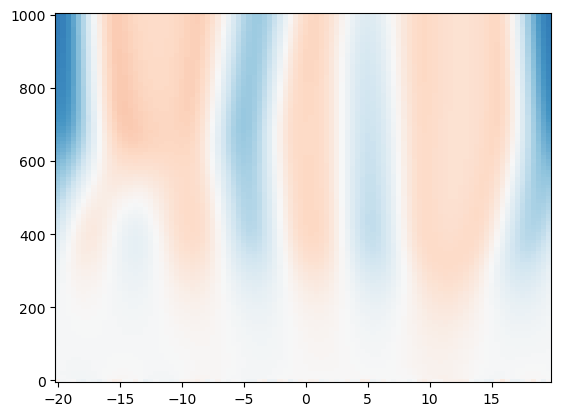

In [6]:
x = dist.local_grid(xbasis, scale=dealias)
fig, ax = plt.subplots()
ax.pcolormesh(x, t_list, np.array(ϕA_list) - np.array(ϕB_list), cmap="RdBu", vmin=-1, vmax=1)

2023-07-26 11:47:45,359 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2023-07-26 11:47:45,360 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x300 -pix_fmt rgba -r 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /var/folders/n8/skcq750x2vdc2nch0nv470wh0000gn/T/tmphldvya8r/temp.m4v


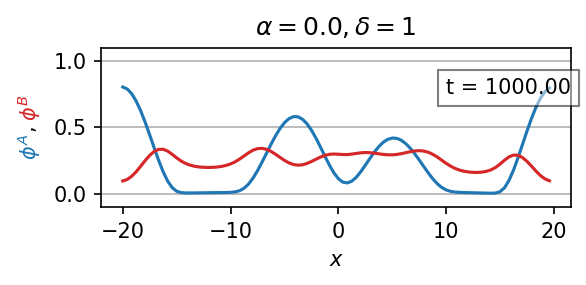

In [7]:
fig, ax = plt.subplots(dpi=150, figsize=(4, 2))

# initialize line
x = dist.local_grid(xbasis, scale=dealias)
lineA, = ax.plot(x, ϕA_list[0], color="C0", label=r"$\phi^A$")
lineB, = ax.plot(x, ϕB_list[0], color="C3", label=r"$\phi^B$")
# line, = ax.plot(x, ϕA_list[0] + ϕB_list[0], color="k")

ax.set(ylim=[-0.1, 1.1],
       xlabel=r"$x$",
       title=rf"$\alpha = {α}, \delta = {np.round(δ, 3)}$")
ax.grid(axis="y")
# ax.legend()
ax.text(-(Lx/2) * 1.50, 0.45, r"$\phi^A$", color="C0", rotation="vertical", va="top")
ax.text(-(Lx/2) * 1.49, 0.5, ",", color="k", rotation="vertical")
ax.text(-(Lx/2) * 1.50, 0.55, r"$\phi^B$", color="C3", rotation="vertical", va="bottom")

timestamp = ax.text(10, 0.75, f"t = {t_list[0]:0.2f}",
                    bbox={'facecolor':'w', 'alpha':0.5})

plt.tight_layout()

def init():
    return [lineA, lineB]

def animate(i):
    lineA.set_xdata(x) # line plot
    lineA.set_ydata(ϕA_list[i]) # line plot

    lineB.set_xdata(x) # line plot
    lineB.set_ydata(ϕB_list[i]) # line plot
    
    timestamp.set_text(f"t = {t_list[i]:0.2f}")
    # line.set_xdata(x) # line plot
    # line.set_ydata(ϕA_list[i] + ϕB_list[i]) # line plot

    return [lineA, lineB]

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(ϕA_list), interval=40, blit=True)
# anim.save(os.path.join("/Users/danny/Library/CloudStorage/GoogleDrive-dsseara@uchicago.edu/My Drive/uchicago/adaptation/schelling/",
#                        f"2023-06-13_meanField_alpha{α}delta{δ}_linearIncompatibility.mp4"))

HTML(anim.to_html5_video())


Calculate the Lyapnuov function for the dynamics.
Note that this function should be monotonic only for $\delta = 0$ (and any $\alpha$) or $\alpha = 1$ (and any $\delta$)

In [33]:
# entropy
S = np.array([- special.xlogy(ϕa, ϕa)
              - special.xlogy(ϕb, ϕb)
              - special.xlogy(1 - ϕa - ϕb, 1 - ϕa - ϕb)
              for ϕa, ϕb in zip(ϕA_list, ϕB_list)])

# global fitness
uA = np.array([ϕa * (4 * ϕa * (1 - ϕa) + δ * 4 * ϕb * (1 - ϕb)) for ϕa, ϕb in zip(ϕA_list, ϕB_list)])
uB = np.array([ϕb * (4 * ϕb * (1 - ϕb) - δ * 4 * ϕa * (1 - ϕa)) for ϕa, ϕb in zip(ϕA_list, ϕB_list)])
u = uA + uB

# link function
lA = np.array([2 * 4 * (ϕa**2 / 2 - ϕa**3 / 3) + 4 * δ * ϕa * ϕb * (1 - ϕb) for ϕa, ϕb in zip(ϕA_list, ϕB_list)])
lB = np.array([2 * 4 * (ϕb**2 / 2 - ϕb**3 / 3) - 4 * δ * ϕa * ϕb * (1 - ϕa) for ϕa, ϕb in zip(ϕA_list, ϕB_list)])
l = (lA + lB) / 2

# gradient
dx = np.diff(x)[0]
gradA = np.array([np.gradient(ϕa, dx) for ϕa in ϕA_list])
gradB = np.array([np.gradient(ϕb, dx) for ϕb in ϕB_list])
grad = (gradA**2 + gradB**2) / 2

lyapunov = T * S + α * u + (1 - α) * l - grad

(None, None)

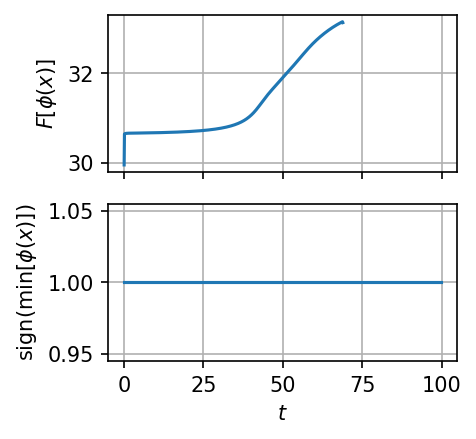

In [34]:
fig, ax = plt.subplots(2, 1, dpi=150, figsize=(3,3), sharex=True)
ax[0].plot(t_list, np.sum(lyapunov, axis=1))
ax[1].plot(t_list, np.sign(np.min(ϕA_list, axis=1)))
ax[0].set(ylabel=r"$F[\phi(x)]$")
ax[1].set(xlabel=r"$t$", ylabel=r"$\mathrm{sign}(\mathrm{min}[\phi(x)])$")
ax[0].grid(), ax[1].grid()

$\alpha = 1, \delta = 1$

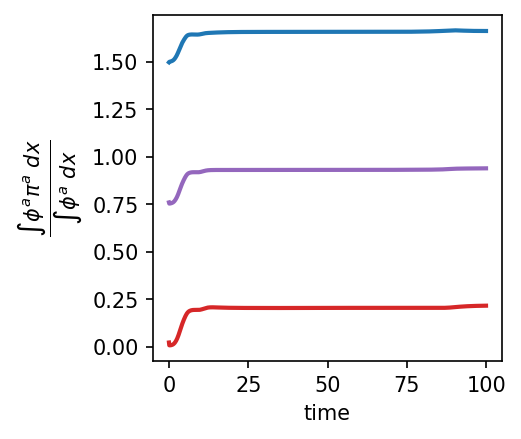

In [81]:
fig, ax = plt.subplots(dpi=150, figsize=(3,3))
ax.plot(t_list, uA.sum(axis=1) / np.sum(ϕA_list[0]), color='C0', lw=2)
ax.plot(t_list, uB.sum(axis=1) / np.sum(ϕB_list[0]), color='C3', lw=2)
ax.plot(t_list, u.sum(axis=1) / (2 * np.sum(ϕB_list[0])), color='C4', lw=2)
ax.set(xlabel="time",
       ylabel=r"$\dfrac{\int \phi^a \pi^a \ dx}{\int \phi^a \ dx}$");

$\alpha = 1, \delta = 0$

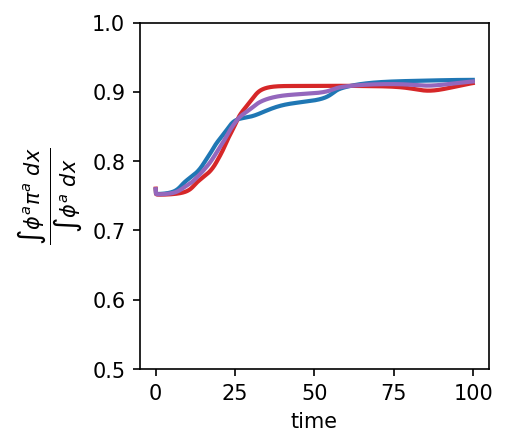

In [73]:
fig, ax = plt.subplots(dpi=150, figsize=(3,3))
ax.plot(t_list, uA.sum(axis=1) / np.sum(ϕA_list[0]), color='C0', lw=2)
ax.plot(t_list, uB.sum(axis=1) / np.sum(ϕB_list[0]), color='C3', lw=2)
ax.plot(t_list, u.sum(axis=1) / (2 * np.sum(ϕB_list[0])), color='C4', lw=2)
ax.set(ylim=[0.5, 1],
       xlabel="time",
       ylabel=r"$\dfrac{\int \phi^a \pi^a \ dx}{\int \phi^a \ dx}$");

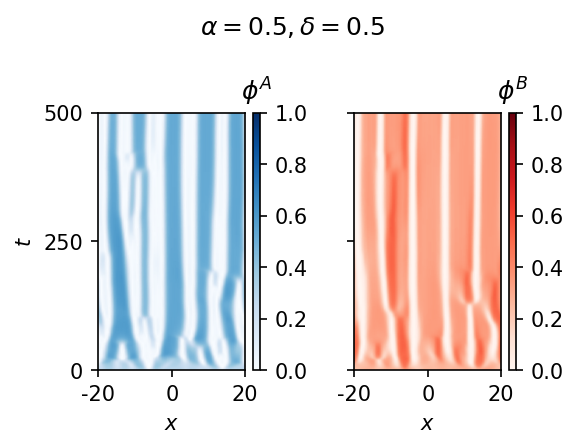

In [40]:
x = dist.local_grid(xbasis, scale=dealias)
fig, ax = plt.subplots(1, 2, dpi=150, figsize=(4, 3), sharey=True)

a0 = ax[0].pcolormesh(x, t_list, ϕA_list,
                      vmin=0, vmax=1,
                      cmap="Blues", shading="gouraud",
                      rasterized=True)
cax0 = ax[0].inset_axes([1.05, 0.0, 0.05, 1])
cbar0 = fig.colorbar(a0, ax=ax[0], cax=cax0)
cbar0.ax.set(title=r"$\phi^A$")
ax[0].set(xticks=[x.min(), 0, x.max()],
          xticklabels=["-" + str(L//2), "0", str(L//2)],
          yticks=[0, t_stop / 2, max(t_list)],
          yticklabels=["0", str(t_stop // 2), str(t_stop)],
          xlabel=r"$x$", ylabel=r"$t$")

a1 = ax[1].pcolormesh(x, t_list, ϕB_list,
                      vmin=0, vmax=1,
                      cmap="Reds", shading="gouraud",
                      rasterized=True)
cax1 = ax[1].inset_axes([1.05, 0.0, 0.05, 1])
cbar1 = fig.colorbar(a1, ax=ax[1], cax=cax1)
cbar1.ax.set(title=r"$\phi^B$")
ax[1].set(xticks=[x.min(), 0, x.max()],
          xticklabels=["-" + str(L//2), "0", str(L//2)],
          yticks=[0, t_stop / 2, max(t_list)],
          yticklabels=["0", str(t_stop // 2), str(t_stop)],
          xlabel=r"$x$")

fig.suptitle(rf"$\alpha = {α}, \delta = {δ}$")
plt.tight_layout()

fig.savefig(os.path.join("/Users/danny/Library/CloudStorage/GoogleDrive-dsseara@uchicago.edu/My Drive/uchicago/adaptation/schelling/",
                         "2023-05-16_meanField_alphaDeltaSweep_randIC/kymo",
                       rf"2023-05-16_meanFieldKymo_alpha{α}delta{δ}_randIC.pdf"))

In [ ]:
def eigenval(q, ϕ, α, δ, T):
    mobility = ϕ * (1 - 2 * ϕ)
    return -q**4 * mobility - q**2 * (T - 4 * mobility * (1 - 2 * ϕ) * (1 - α) - 4 * 1j * δ * mobility * np.abs(1 - 3 * α - 2 * ϕ * (1 - α)))

In [40]:
mpl.rcParams["text.usetex"] = True

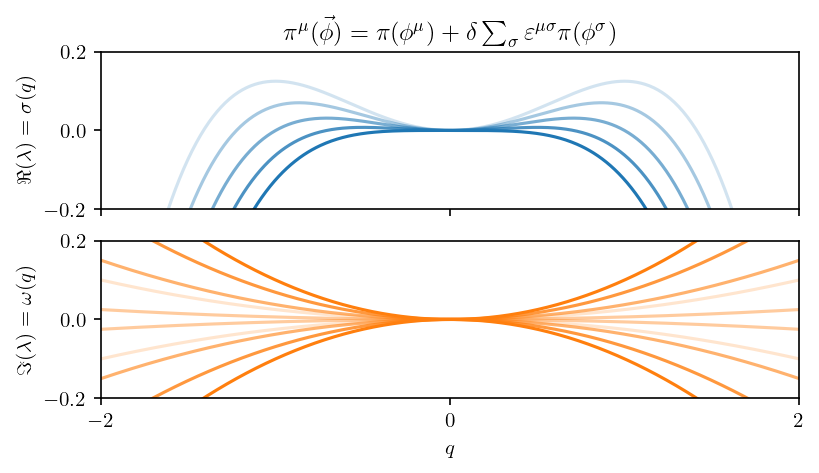

In [43]:
T = 0
α = 0
δ = 0.1
ϕ = 0.25

q = np.linspace(-2, 2, 501)
fig, ax = plt.subplots(2, dpi=150, figsize=(6,3), sharex=True)
for idx, α in enumerate([0, 0.25, 0.5, 0.75, 1.0]):
    if idx == 4:
        ax[0].plot(q, np.real(eigenval(q, ϕ, α, δ, T)), color="C0", label=r"$\sigma$", alpha=(idx+1)/5)
        ax[1].plot(q, np.imag(eigenval(q, ϕ, α, δ, T)), color="C1", label=r"$\omega$", alpha=(idx+1)/5)
    else:
        ax[0].plot(q, np.real(eigenval(q, ϕ, α, δ, T)), color="C0", alpha=(idx+1)/5)
        ax[1].plot(q, np.imag(eigenval(q, ϕ, α, δ, T)), color="C1", alpha=(idx+1)/5)
    ax[1].plot(q, np.imag(eigenval(q, ϕ, α, -δ, T)), color="C1", alpha=(idx+1)/5)
ax[0].set(ylabel=r"$\Re(\lambda) = \sigma(q)$",
       ylim=[-0.2, 0.2], yticks=[-0.2, 0, 0.2],
       xlim=[q.min(), q.max()])
ax[1].set(xlabel=r"$q$", ylabel=r"$\Im(\lambda) = \omega(q)$",
       ylim=[-0.2, 0.2], yticks=[-0.2, 0, 0.2],
       xlim=[q.min(), q.max()], xticks=[q.min(), 0, q.max()])
ax[0].set(title=r"$\pi^\mu(\vec{\phi}) = \pi(\phi^\mu) + \delta \sum_\sigma \varepsilon^{\mu \sigma} \pi(\phi^\sigma)$");
# ax.legend()